Hemos tratado satisfactoriamente los archivos de excel en foundational_dataset.ipnb. Ahora vamos a cargar el archivo obtenido al final de esa notebook:

In [62]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data\processed/foundational_dataset.csv")
print(df.head())



            FECHA_HORA  EE Planta / Hl  EE Elaboracion / Hl  EE Bodega / Hl  \
0  2020-07-01 23:59:00      642.727209            47.145349       69.023256   
1  2020-07-02 23:59:00        7.767254             0.769609        0.798838   
2  2020-07-03 23:59:00        8.801205             0.862593        0.835762   
3  2020-07-04 23:59:00        5.175639             0.439225        0.371077   
4  2020-07-05 23:59:00        7.924665             0.802365        0.717787   

   EE Cocina / Hl  EE Envasado / Hl  EE Linea 2 / Hl  EE Linea 3 / Hl  \
0        0.000000         13.813953        14.578784         0.000000   
1        0.319229          2.358593         4.158962         1.506838   
2        0.260924          1.985462        39.076667         1.448962   
3        0.258048          1.442114         4.348182         1.355238   
4        0.301592          1.664726         5.125920         2.704348   

   EE Linea 4 / Hl  EE Servicios / Hl  ...  Agua Calderas  Agua Efluentes  \
0        

In [63]:
#antes de comenzar el analisis exploratorio
#vamos a definir algunas variables que seguramente serán utiles

import numpy as np
df["Frio_diff1_lag1"] = df["Frio (Kw)"].astype(float).diff().shift(1)
df["Frio_diff7_lag1"] = df["Frio (Kw)"].astype(float).diff().shift(1)
roll_windows = [3, 7, 14,28]
for window in roll_windows:
    df[f"Frio_roll_mean_{window}_lag1"] = df["Frio (Kw)"].astype(float).shift(1).rolling(window=window).mean()
    df[f"Frio_roll_std_{window}_lag1"] = df["Frio (Kw)"].astype(float).shift(1).rolling(window=window).std()



y = df["Frio (Kw)"].shift(-1)  # este va a ser nuestro target!
y.dropna(inplace=True) #nos va a quedar una fila menos
X = df.loc[y.index]

In [64]:

import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


# Vamos a efectuar el analisis exploratorio sobre el conjunto de train
# Definiremos como test al último 30% del dataset
n_test = int(len(df) * 0.30)
n_train = len(df) - n_test

# Split temporal

x_test = X.iloc[n_train:].copy()
x_train = X.iloc[:n_train].copy()
y_test = y.iloc[n_train:].copy()
y_train = y.iloc[:n_train].copy()
print(f"\nTrain: {len(x_train)} registros ({len(x_train)/len(df)*100:.1f}%)")
print(f"  Fechas: {x_train['FECHA_HORA'].min()} a {x_train['FECHA_HORA'].max()}")
print(f"\nTest: {len(x_test)} registros ({len(x_test)/len(df)*100:.1f}%)")
print(f"  Fechas: {x_test['FECHA_HORA'].min()} a {x_test['FECHA_HORA'].max()}")




x_train.drop(columns=["FECHA_HORA"], inplace=True)
x_test.drop(columns=["FECHA_HORA"], inplace=True)


Train: 833 registros (70.0%)
  Fechas: 2020-07-01 23:59:00 a 2022-10-28 23:59:00

Test: 356 registros (29.9%)
  Fechas: 2022-10-29 23:59:00 a 2023-10-25 23:59:00


In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

# Alinear columnas entre train y test (mismas y en el mismo orden)
common_cols = [c for c in x_train.columns if c in x_test.columns]
if not common_cols:
    raise ValueError("Train y test no comparten columnas")
x_train = x_train[common_cols].copy()
x_test = x_test[common_cols].copy()

# Separar numéricas y otras
numeric_cols = x_train.select_dtypes(include=[np.number]).columns.tolist()
other_cols = [c for c in x_train.columns if c not in numeric_cols]

# Trabajar solo con numéricas para outliers/imputación
Xtr_num = x_train[numeric_cols].copy()
Xte_num = x_test.reindex(columns=numeric_cols).copy()

# Límites por feature con MAD (fallback a percentiles si MAD=0)
def mad_bounds(col_train: pd.Series, Z: float = 3.5,
               q_low: float = 0.001, q_high: float = 0.999):
    med = col_train.median()
    mad = np.median(np.abs(col_train - med))
    if mad > 0:
        low  = med - (Z * mad / 0.6745)
        high = med + (Z * mad / 0.6745)
    else:
        low  = col_train.quantile(q_low)
        high = col_train.quantile(q_high)
        if low == high:
            low, high = low - 1e-12, high + 1e-12
    return low, high

bounds = {c: mad_bounds(Xtr_num[c].dropna(), Z=3.5, q_low=0.001, q_high=0.999)
          for c in numeric_cols}

def mask_outliers_to_nan(df_num: pd.DataFrame, bounds_dict: dict) -> pd.DataFrame:
    df = df_num.copy()
    for c, (low, high) in bounds_dict.items():
        mask_low  = df[c] < low
        mask_high = df[c] > high
        df.loc[mask_low | mask_high, c] = np.nan
    return df

Xtr_num_nan = mask_outliers_to_nan(Xtr_num, bounds)
Xte_num_nan = mask_outliers_to_nan(Xte_num, bounds)

# Conteo de celdas nan-eadas por outliers
tr_nan_cells = Xtr_num_nan.isna().sum().sum() - Xtr_num.isna().sum().sum()
te_nan_cells = Xte_num_nan.isna().sum().sum() - Xte_num.isna().sum().sum()
print(f"Celdas convertidas a NaN por outliers - train: {tr_nan_cells}, test: {te_nan_cells}")

# Vamos a eliminar de este procesamiento a las columnas con muchísimos NaN
nan_threshold = 0.95
high_nan_cols = Xtr_num_nan.columns[Xtr_num_nan.isna().mean() > nan_threshold].tolist()
print(f"Eliminando {len(high_nan_cols)} columnas con >{nan_threshold*100}% NaN")

numeric_cols_clean = [c for c in numeric_cols if c not in high_nan_cols]
Xtr_num_clean = Xtr_num_nan[numeric_cols_clean].copy()
Xte_num_clean = Xte_num_nan[numeric_cols_clean].copy()

# Imputación KNN en espacio escalado y volver a original
scaler = RobustScaler()
Xtr_scaled_arr = scaler.fit_transform(Xtr_num_clean)
Xte_scaled_arr = scaler.transform(Xte_num_clean)

Xtr_scaled = pd.DataFrame(Xtr_scaled_arr, columns=numeric_cols_clean, index=Xtr_num_clean.index)
Xte_scaled = pd.DataFrame(Xte_scaled_arr, columns=numeric_cols_clean, index=Xte_num_clean.index)

imputer = KNNImputer(n_neighbors=5, weights='distance')
Xtr_imp_scaled_arr = imputer.fit_transform(Xtr_scaled)
Xte_imp_scaled_arr = imputer.transform(Xte_scaled)

Xtr_imp_scaled = pd.DataFrame(Xtr_imp_scaled_arr, columns=numeric_cols_clean, index=Xtr_scaled.index)
Xte_imp_scaled = pd.DataFrame(Xte_imp_scaled_arr, columns=numeric_cols_clean, index=Xte_scaled.index)

# Volver a escala original
Xtr_imp = pd.DataFrame(scaler.inverse_transform(Xtr_imp_scaled),
                       columns=numeric_cols_clean, index=Xtr_imp_scaled.index)
Xte_imp = pd.DataFrame(scaler.inverse_transform(Xte_imp_scaled),
                       columns=numeric_cols_clean, index=Xte_imp_scaled.index)

# Rellenar columnas eliminadas con 0, no podemos imputarlas de una manera mejor
for col in high_nan_cols:
    Xtr_imp[col] = 0
    Xte_imp[col] = 0

# Asegurar orden de columnas original
Xtr_imp = Xtr_imp[numeric_cols]
Xte_imp = Xte_imp[numeric_cols]

# Reconstruir datasets finales, orden de columnas igual a train
x_train_clean = pd.concat(
    [Xtr_imp.reset_index(drop=True),
     x_train[other_cols].reset_index(drop=True)],
    axis=1
)[x_train.columns]

x_test_clean = pd.concat(
    [Xte_imp.reset_index(drop=True),
     x_test[other_cols].reset_index(drop=True)],
    axis=1
)[x_train.columns]

# Resultado final para modelar
x_train = x_train_clean
x_test  = x_test_clean

print(f"\nForma final - train: {x_train.shape}, test: {x_test.shape}")
print(f"NaNs restantes - train: {x_train.isna().sum().sum()}, test: {x_test.isna().sum().sum()}")

Celdas convertidas a NaN por outliers - train: 4693, test: 3430
Eliminando 85 columnas con >95.0% NaN

Forma final - train: (833, 225), test: (356, 225)
NaNs restantes - train: 0, test: 0


In [66]:
# Calcular coeficiente de variación (CV)
std_devs = x_train.std()
medias = x_train.abs().mean()  # valor absoluto para evitar divisiones problemáticas

# Evitar división por cero
cv = np.where(medias > 1e-10, std_devs / medias, np.inf)
cv_series = pd.Series(cv, index=x_train.columns)

# Filtrar solo numéricas
numeric_mask = x_train.select_dtypes(include=[np.number]).columns
cv_numeric = cv_series[numeric_mask]

# Contar varianza baja
count_low_variance = (cv_numeric < 0.1).sum()

print("Coeficiente de Variación (CV) por columna:")
print(cv_numeric.sort_values())
print("-" * 40)
print(f"📊 Columnas con CV < 0.1 (variabilidad muy baja): {count_low_variance}")
print("-" * 40)
print("\nColumnas a considerar eliminar:")
print(cv_numeric[cv_numeric < 0.1].sort_values())
print(cv_numeric[cv_numeric < 0.1].index.tolist())

Coeficiente de Variación (CV) por columna:
CO 2 Linea 4 / Hl           0.027154
Linea 4 (Kw)                0.036854
Agua Cocina / Hl            0.071714
EE Linea 4 / Hl             0.084529
Produccion Agua / Hl        0.102743
                              ...   
Cocimientos Diarios              inf
Tot Vap Lav L3 / Hora            inf
Medicion Gas Planta (M3)         inf
Unnamed: 123                     inf
Tot Vap Paste L3 / Hora          inf
Length: 225, dtype: float64
----------------------------------------
📊 Columnas con CV < 0.1 (variabilidad muy baja): 4
----------------------------------------

Columnas a considerar eliminar:
CO 2 Linea 4 / Hl    0.027154
Linea 4 (Kw)         0.036854
Agua Cocina / Hl     0.071714
EE Linea 4 / Hl      0.084529
dtype: float64
['EE Linea 4 / Hl', 'Agua Cocina / Hl', 'CO 2 Linea 4 / Hl', 'Linea 4 (Kw)']


In [67]:
#Vamos a eliminar las columnas con varianza muy baja
low_variance_cols = cv_numeric[cv_numeric < 0.1].index.tolist()
print(f"Eliminando {len(low_variance_cols)} columnas con varianza muy baja")
x_train.drop(columns=low_variance_cols, inplace=True)
x_test.drop(columns=low_variance_cols, inplace=True)


Eliminando 4 columnas con varianza muy baja


In [68]:
x_train.head()

,EE Planta / Hl,EE Elaboracion / Hl,EE Bodega / Hl,EE Cocina / Hl,EE Envasado / Hl,EE Linea 2 / Hl,EE Linea 3 / Hl,EE Servicios / Hl,EE Sala Maq / Hl,EE Frio / Hl,...,Frio_diff1_lag1,Frio_diff7_lag1,Frio_roll_mean_3_lag1,Frio_roll_std_3_lag1,Frio_roll_mean_7_lag1,Frio_roll_std_7_lag1,Frio_roll_mean_14_lag1,Frio_roll_std_14_lag1,Frio_roll_mean_28_lag1,Frio_roll_std_28_lag1
0,8.621794,1.069000,0.949469,0.291047,1.055282,1.882134,1.833394,5.658765,3.773341,3.052278,...,-4798.392287,-4798.392287,20511.897121,3684.574377,21253.291708,5233.537384,23447.879447,4620.772983,25970.606588,5409.771187
1,7.767254,0.769609,0.798838,0.319229,2.358593,4.158962,1.506838,5.429388,3.885211,3.419545,...,2815.578485,2815.578485,25085.614555,3005.799469,25769.438107,3023.044816,25481.024942,3197.342871,25607.813714,3823.409839
2,8.801205,0.862593,0.835762,0.260924,1.985462,2.871431,1.448962,5.703346,4.205406,3.787626,...,9629.000000,9629.000000,28164.477461,2124.376035,29976.210503,2929.066619,29413.973624,3550.224660,29057.426815,3472.104270
3,5.175639,0.439225,0.371077,0.258048,1.442114,4.348182,1.355238,3.058399,2.165177,1.870213,...,4314.000000,4314.000000,22182.333333,7138.341147,29487.606156,3075.262568,30023.015538,2902.842710,30011.245506,3535.015301
4,7.924665,0.802365,0.717787,0.301592,1.664726,5.125920,2.704348,5.094301,3.756100,3.354482,...,-4022.000000,-4022.000000,25489.333333,2410.820884,29533.119889,2772.758951,30055.476269,3213.062694,30936.189940,4189.078618


In [69]:
# Gracias a un modelo de lenguaje, hemos conseguido candidatos a ser eliminados
# Usando el prompt:
# "Eres un ingeniero, especializado en ciencia de datos, trabajando con un conjunto de datos de consumo energético.
# Una empresa de producción de cerveza te ha contratado para generar un modelo que prediga el consumo de energía de sus sistemas de refrigeración.
# El conjunto de datos contiene múltiples características, algunas de las cuales pueden no ser relevantes para la predicción del consumo de energía.
# Analiza las siguientes columnas y determina cuáles podrían ser eliminadas del conjunto de datos para mejorar el rendimiento del modelo, justificando tu elección:
# ..."

# Ahora, analizaremos la correlacion de pearson y spearman sobre los candidatos

analizar_corr=[
 'Agua Bodega / Hl', 'Agua Dilucion (Hl)', 'Agua Elab / Hl', 
 'Agua Envas / Hl', 'Agua Linea 2/Hl', 'Agua Linea 3/Hl', 'Agua Linea 4/Hl', 'Agua Planta / Hl', 'Agua Planta de Agua/Hl', 
 'Agua Servicios (Hl)', 'Agua Servicios/Hl', 'Aire Bodega / Hl', 
 'Aire Cocina / Hl', 'Aire Elaboracion (m3)', 'Aire Elaboracion / Hl', 
 'Aire Envasado (M3)', 'Aire Envasado / Hl', 'Aire L2 / Hl', 'Aire L3 / Hl', 
 'Aire L4 / Hl', 'Aire Planta / Hl', 'Aire Servicios (M3)', 
 'Aire Servicios / Hl', 'CO 2 / Hl', 'CO 2 Filtro / Hl',  
 'CO 2 linea 3 / Hl', 'Conversion Kg/Mj', 'EE Agua / Hl', 
 'EE Aire / Hl', 'EE CO2 / Hl', 'EE Caldera / Hl', 'EE Eflu / Hl', 
 'EE Linea 2 / Hl', 'EE Linea 3 / Hl', 
 'EE Resto Planta / Hl', 'EE Resto Serv / Hl', 
 'EE Servicios / Hl', 'ET Bodega/Hl', 'ET Cocina/Hl', 'ET Elab/Hl', 
 'ET Elaboracion (Mj)', 'ET Envasado (Mj)', 'ET Envasado/Hl', 
 'ET Linea 2/Hl', 'ET Linea 3/Hl', 'ET Linea 4/Hl', 
 'ET Planta / Hl', 'ET Servicios (Mj)', 'ET Servicios / Hl', 
 'FC Barriles', 'FC L1 y L2', 'FC Lavadora L2', 'FC Lavadora L3', 
 'Produccion Agua / Hl', 'Red L1 y L2', 'Red L3', 'Red Paste L4',
 'Tot Aire Expulsion', 'Tot_Vapor_CIP_Bodega', 'Tot_Vapor_L3_L4', 
 'Totaliador_Aire_L4', 'Totalizador_Aire_Bodega', 'Totalizador_Aire_Cocina', 
 'Totalizador_Aire_L2', 'Totalizador_Aire_L3', 'Totalizador_Aire_L5', 
 'VAPOR DE LINEA 1 Y 2 KG', 'VAPOR DE LINEA 4 KG', 'Vapor L3', 
 'Vapor Servicio (Kg)'
]

import numpy as np
import pandas as pd

MIN_PARES = 30     # mínimo de filas válidas para calcular correlación
umbral = 0.30      # umbral de |corr| para filtrar

# 1) Definir candidatos presentes en X (evita errores de nombres ausentes)
candidate_cols = [c for c in analizar_corr if c in x_train.columns]

# 2) Asegurar que y_train sea una Serie y esté alineada a x_train
if isinstance(y_train, pd.DataFrame):
    assert y_train.shape[1] == 1, "y_train debe tener una sola columna"
    y = y_train.iloc[:, 0]
else:
    y = y_train

# Alinear índices por si hubo shuffles/splits
y = y.reindex(x_train.index)

def pair_corr_from_series(s_x, s_y, min_pairs=MIN_PARES, method='pearson'):
    s1 = pd.to_numeric(s_y, errors='coerce')
    s2 = pd.to_numeric(s_x, errors='coerce')
    valid = s1.notna() & s2.notna()
    if valid.sum() < min_pairs:
        return np.nan
    return s1[valid].corr(s2[valid], method=method)

# 3) Calcular Pearson y Spearman por columna
pearson = pd.Series(
    {c: pair_corr_from_series(x_train[c], y, method='pearson') for c in candidate_cols},
    name='pearson'
)

spearman = pd.Series(
    {c: pair_corr_from_series(x_train[c], y, method='spearman') for c in candidate_cols},
    name='spearman'
)

# 4) Consolidar resultados
corrs_df = pd.concat([pearson, spearman], axis=1).dropna(how='all')

# 5) Filtrar columnas según umbral con ambas métricas
cols_bajas = corrs_df.index[
    (corrs_df['pearson'].abs() < umbral) & (corrs_df['spearman'].abs() < umbral)
].tolist()

cols_altas = corrs_df.index[
    (corrs_df['pearson'].abs() >= umbral) | (corrs_df['spearman'].abs() >= umbral)
].tolist()

print(f"Columnas evaluadas: {len(corrs_df)}")
print(f"Con |corr| < {umbral} en ambas: {len(cols_bajas)}")
print(f"Con |corr| >= {umbral} en alguna: {len(cols_altas)}")

# Vista rápida: top por correlación absoluta (máx. entre Pearson/Spearman)
preview = (
    corrs_df
    .assign(max_abs=corrs_df.abs().max(axis=1))
    .sort_values('max_abs', ascending=False)
)

#ahora eliminamos las columnas con baja correlacion
x_train.drop(columns=cols_bajas, inplace=True)
x_test.drop(columns=cols_bajas, inplace=True)


Columnas evaluadas: 70
Con |corr| < 0.3 en ambas: 49
Con |corr| >= 0.3 en alguna: 21


In [70]:
#ahora calculemos la correlacion de pearson y spearman de todas las columnas con el target
analizar_corr = x_train.columns.tolist()

# 3) Calcular Pearson y Spearman por columna
pearson = pd.Series(
    {c: pair_corr_from_series(x_train[c], y, method='pearson') for c in analizar_corr},
    name='pearson'
)

spearman = pd.Series(
    {c: pair_corr_from_series(x_train[c], y, method='spearman') for c in analizar_corr},
    name='spearman'
)

# 4) Consolidar resultados
corrs_df = pd.concat([pearson, spearman], axis=1).dropna(how='all')

# 5) Filtrar columnas según umbral con ambas métricas
cols_bajas = corrs_df.index[
    (corrs_df['pearson'].abs() < umbral) & (corrs_df['spearman'].abs() < umbral)
].tolist()

cols_altas = corrs_df.index[
    (corrs_df['pearson'].abs() >= umbral) | (corrs_df['spearman'].abs() >= umbral)
].tolist()

print(f"Columnas evaluadas: {len(corrs_df)}")
print(f"Con |corr| < {umbral} en ambas: {len(cols_bajas)}")
print(f"Con |corr| >= {umbral} en alguna: {len(cols_altas)}")

# Vista rápida: top por correlación absoluta (máx. entre Pearson/Spearman)
preview = (
    corrs_df
    .assign(max_abs=corrs_df.abs().max(axis=1))
    .sort_values('max_abs', ascending=False)
)

Columnas evaluadas: 87
Con |corr| < 0.3 en ambas: 27
Con |corr| >= 0.3 en alguna: 60


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Seleccionar las top 20 variables más correlacionadas
top_20_vars = preview.head(20).index.tolist()



# Opcional: Mostrar las variables seleccionadas
print("\n📊 Top 20 variables más correlacionadas con el target:")
print("="*60)
for i, var in enumerate(top_20_vars, 1):
    p_val = preview.loc[var, 'pearson']
    s_val = preview.loc[var, 'spearman']
    print(f"{i:2d}. {var:30s} | Pearson: {p_val:+.3f} | Spearman: {s_val:+.3f}")


📊 Top 20 variables más correlacionadas con el target:
 1. Frio (Kw)                      | Pearson: +0.148 | Spearman: +0.836
 2. Sala Maq (Kw)                  | Pearson: +0.145 | Spearman: +0.824
 3. Frio_roll_mean_14_lag1         | Pearson: +0.085 | Spearman: +0.813
 4. Frio_roll_mean_7_lag1          | Pearson: +0.085 | Spearman: +0.809
 5. Servicios (Kw)                 | Pearson: +0.107 | Spearman: +0.806
 6. mes_cos                        | Pearson: -0.087 | Spearman: -0.786
 7. KW Gral Planta                 | Pearson: +0.110 | Spearman: +0.781
 8. Frio_roll_mean_3_lag1          | Pearson: +0.091 | Spearman: +0.780
 9. Frio_roll_mean_28_lag1         | Pearson: +0.081 | Spearman: +0.779
10. Planta (Kw)                    | Pearson: +0.108 | Spearman: +0.775
11. ET Bodega/Hl                   | Pearson: -0.095 | Spearman: -0.721
12. Agua Planta (Hl)               | Pearson: +0.083 | Spearman: +0.704
13. ET Servicios / Hl              | Pearson: -0.098 | Spearman: -0.699
14. Plant

🔍 ANÁLISIS DE MULTICOLINEALIDAD ENTRE PREDICTORES

📊 Seleccionando top 20 variables más correlacionadas con el target...
Variables en análisis: 20

1️⃣  MATRIZ DE CORRELACIÓN (PEARSON)


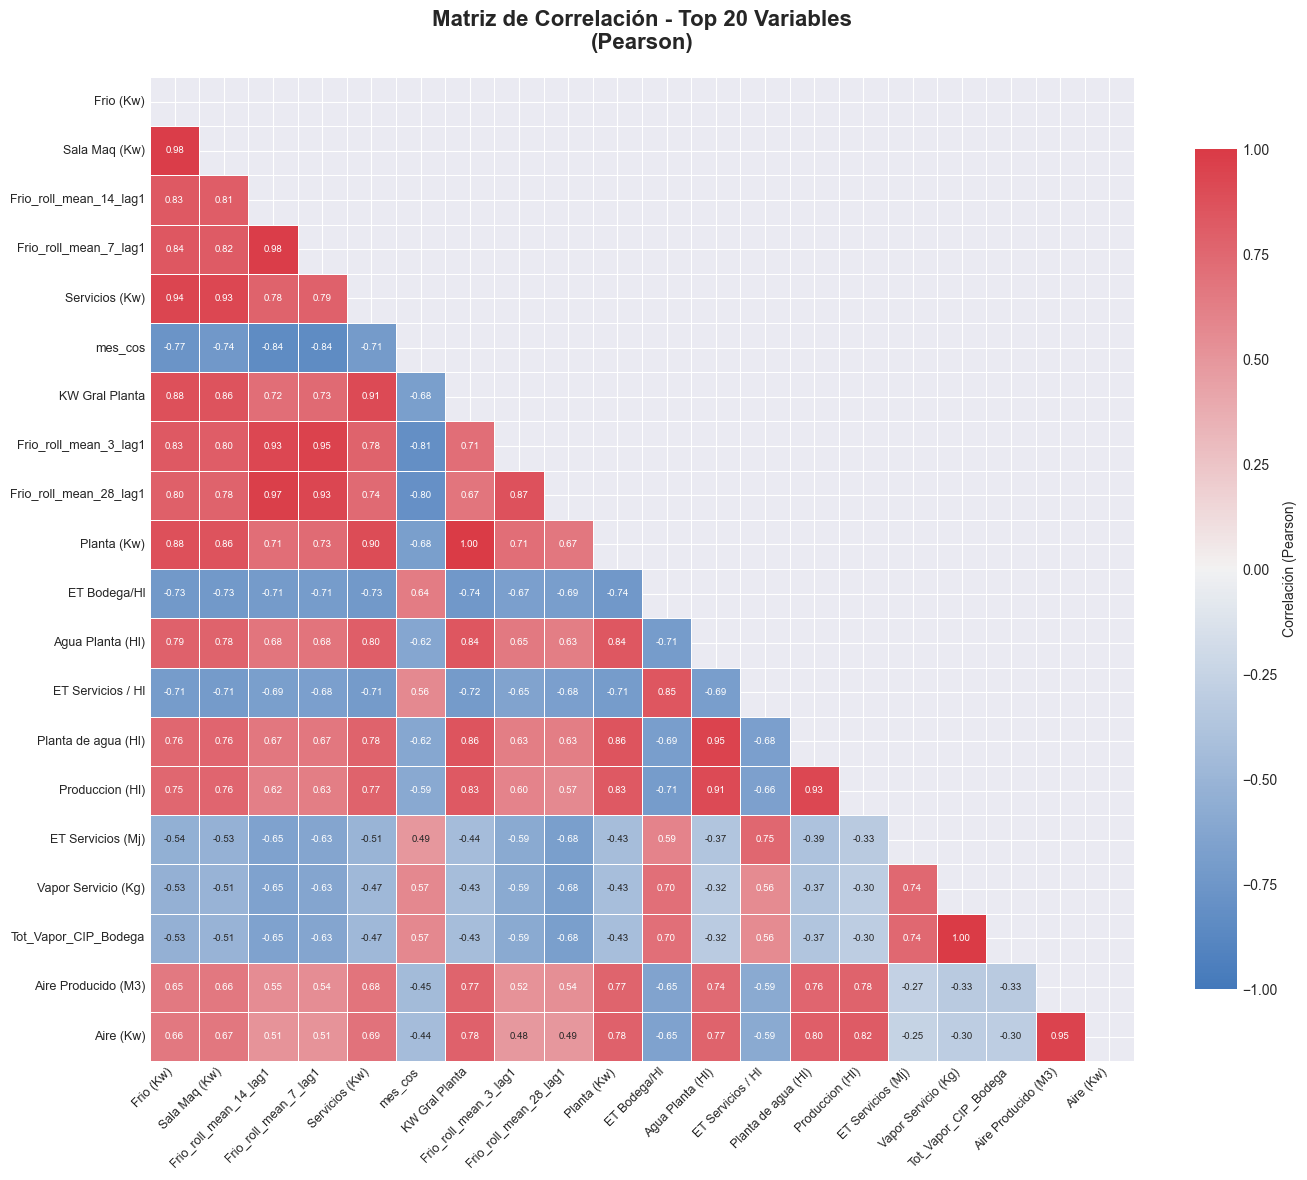


2️⃣  PARES CON CORRELACIÓN |r| >= 0.7
            Variable_1             Variable_2  Correlacion  Abs_Correlacion
   Vapor Servicio (Kg)   Tot_Vapor_CIP_Bodega     1.000000         1.000000
        KW Gral Planta            Planta (Kw)     0.999247         0.999247
             Frio (Kw)          Sala Maq (Kw)     0.977215         0.977215
Frio_roll_mean_14_lag1  Frio_roll_mean_7_lag1     0.976599         0.976599
Frio_roll_mean_14_lag1 Frio_roll_mean_28_lag1     0.970373         0.970373
 Frio_roll_mean_7_lag1  Frio_roll_mean_3_lag1     0.954283         0.954283
      Agua Planta (Hl)    Planta de agua (Hl)     0.952754         0.952754
   Aire Producido (M3)              Aire (Kw)     0.947704         0.947704
             Frio (Kw)         Servicios (Kw)     0.944472         0.944472
 Frio_roll_mean_7_lag1 Frio_roll_mean_28_lag1     0.930959         0.930959
         Sala Maq (Kw)         Servicios (Kw)     0.928760         0.928760
Frio_roll_mean_14_lag1  Frio_roll_mean_3_lag1    

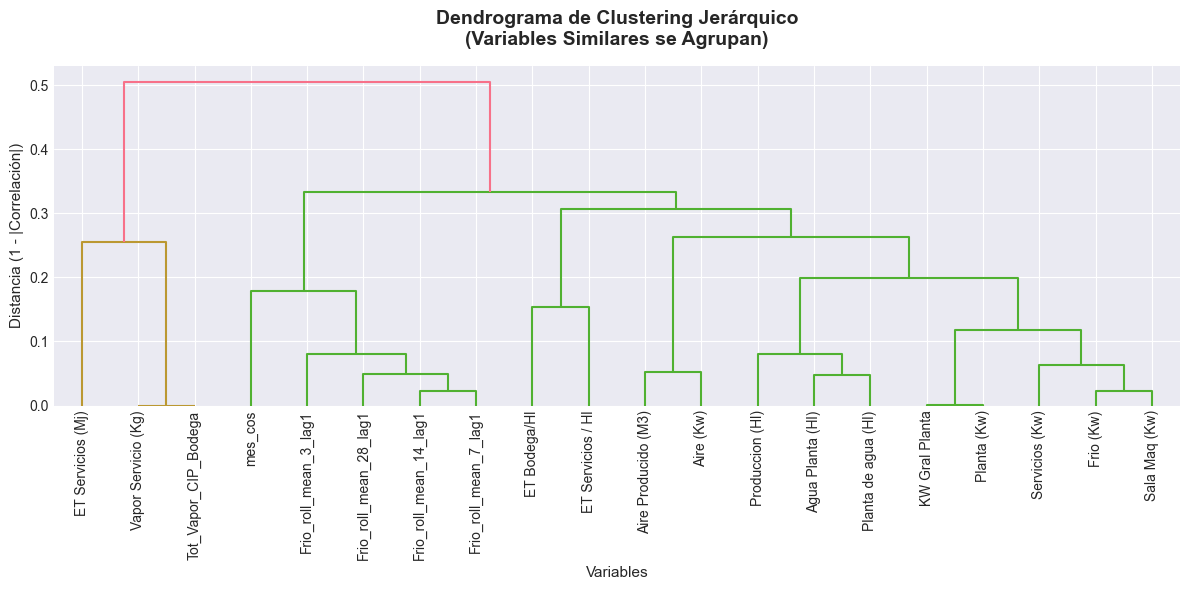


5️⃣  HEATMAP CON CLUSTERING


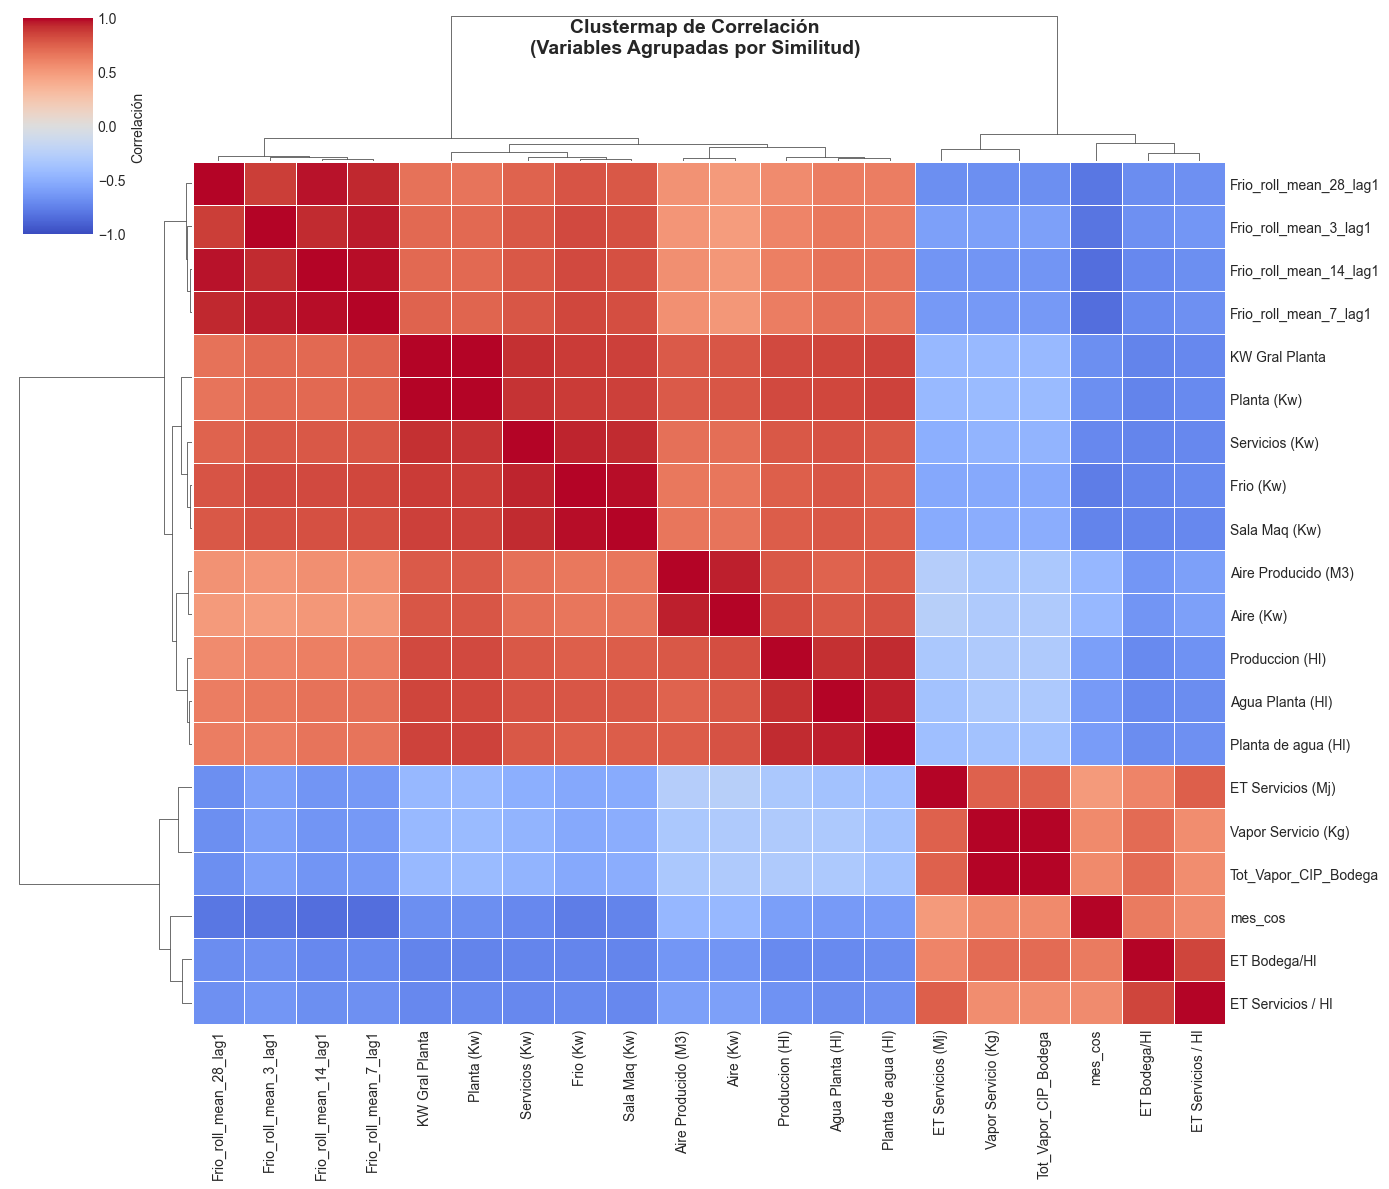


📋 RESUMEN Y RECOMENDACIONES

✓ Variables analizadas: 20
✓ Pares con |r| >= 0.7: 91
✓ Variables con VIF > 10: 19

💡 Recomendaciones:



In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# =============================================================================
# 1. MATRIZ DE CORRELACIÓN Y HEATMAP TRIANGULAR
# =============================================================================

def plot_correlation_heatmap(df, top_n=20, method='pearson', figsize=(14, 12)):
    """
    Genera heatmap triangular de correlación
    """
    # Calcular matriz de correlación
    if method == 'pearson':
        corr_matrix = df.corr()
    elif method == 'spearman':
        corr_matrix = df.corr(method='spearman')
    
    # Seleccionar top N variables si hay más
    if len(df.columns) > top_n:
        # Calcular correlación promedio con todas las demás
        mean_corr = corr_matrix.abs().mean().sort_values(ascending=False)
        top_vars = mean_corr.head(top_n).index
        corr_matrix = corr_matrix.loc[top_vars, top_vars]
    
    # Máscara triangular superior
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Crear figura
    fig, ax = plt.subplots(figsize=figsize)
    
    # Heatmap
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": f"Correlación ({method.capitalize()})"},
        annot=True,
        fmt='.2f',
        annot_kws={'size': 7},
        vmin=-1,
        vmax=1
    )
    
    plt.title(f'Matriz de Correlación - Top {len(corr_matrix)} Variables\n({method.capitalize()})', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    
    return fig, corr_matrix


# =============================================================================
# 2. DETECCIÓN DE PARES ALTAMENTE CORRELACIONADOS
# =============================================================================

def find_high_correlations(corr_matrix, threshold=0.7):
    """
    Identifica pares de variables con correlación alta
    """
    # Obtener triángulo superior sin diagonal
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Encontrar pares con correlación > threshold
    high_corr_pairs = []
    for col in upper_tri.columns:
        for idx in upper_tri.index:
            corr_val = upper_tri.loc[idx, col]
            if pd.notna(corr_val) and abs(corr_val) >= threshold:
                high_corr_pairs.append({
                    'Variable_1': idx,
                    'Variable_2': col,
                    'Correlacion': corr_val,
                    'Abs_Correlacion': abs(corr_val)
                })
    
    df_pairs = pd.DataFrame(high_corr_pairs).sort_values(
        'Abs_Correlacion', ascending=False
    ).reset_index(drop=True)
    
    return df_pairs


# =============================================================================
# 3. CÁLCULO DE VIF (Variance Inflation Factor)
# =============================================================================

def calculate_vif(df, threshold=10):
    """
    Calcula VIF para detectar multicolinealidad
    VIF > 10 indica multicolinealidad severa
    VIF > 5 indica multicolinealidad moderada
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    # Eliminar columnas con varianza cero
    df_clean = df.loc[:, df.std() > 0]
    
    vif_data = []
    for i, col in enumerate(df_clean.columns):
        try:
            vif_value = variance_inflation_factor(df_clean.values, i)
            vif_data.append({
                'Variable': col,
                'VIF': vif_value,
                'Nivel': 'Severo' if vif_value > threshold else 
                         'Moderado' if vif_value > 5 else 'Bajo'
            })
        except:
            vif_data.append({
                'Variable': col,
                'VIF': np.nan,
                'Nivel': 'Error'
            })
    
    vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
    return vif_df


# =============================================================================
# 4. CLUSTERING JERÁRQUICO DE VARIABLES
# =============================================================================

def plot_correlation_dendrogram(corr_matrix, figsize=(12, 6)):
    """
    Dendrograma para agrupar variables similares
    """
    # Convertir correlación a distancia (1 - |corr|)
    dissimilarity = 1 - abs(corr_matrix)
    
    # Clustering jerárquico
    Z = hierarchy.linkage(squareform(dissimilarity), method='average')
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    dendro = hierarchy.dendrogram(
        Z,
        labels=corr_matrix.columns,
        leaf_rotation=90,
        leaf_font_size=10,
        ax=ax
    )
    
    plt.title('Dendrograma de Clustering Jerárquico\n(Variables Similares se Agrupan)', 
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Variables', fontsize=11)
    plt.ylabel('Distancia (1 - |Correlación|)', fontsize=11)
    plt.tight_layout()
    
    return fig, Z


# =============================================================================
# 5. MATRIZ DE CORRELACIÓN REORDENADA (CLUSTERMAP)
# =============================================================================

def plot_clustered_correlation(corr_matrix, figsize=(14, 12)):
    """
    Heatmap con clustering para visualizar grupos de variables
    """
    g = sns.clustermap(
        corr_matrix,
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=0.5,
        figsize=figsize,
        cbar_kws={"shrink": 0.8, "label": "Correlación"},
        dendrogram_ratio=0.15,
        method='average'
    )
    
    g.fig.suptitle('Clustermap de Correlación\n(Variables Agrupadas por Similitud)', 
                   fontsize=14, fontweight='bold', y=0.98)
    
    return g


# =============================================================================
# 6. REPORTE COMPLETO DE MULTICOLINEALIDAD
# =============================================================================

def analisis_multicolinealidad_completo(df, target_corr_df=None, top_n=20, 
                                       corr_threshold=0.7, vif_threshold=10):
    """
    Ejecuta análisis completo de multicolinealidad
    
    Parameters:
    -----------
    df : DataFrame con las variables predictoras
    target_corr_df : DataFrame con correlaciones con el target (opcional)
    top_n : número de variables a analizar
    corr_threshold : umbral para detectar correlación alta
    vif_threshold : umbral para VIF
    """
    
    print("="*80)
    print("🔍 ANÁLISIS DE MULTICOLINEALIDAD ENTRE PREDICTORES")
    print("="*80)
    
    # Seleccionar variables a analizar
    if target_corr_df is not None and len(df.columns) > top_n:
        print(f"\n📊 Seleccionando top {top_n} variables más correlacionadas con el target...")
        top_vars = target_corr_df.head(top_n).index.tolist()
        df_analysis = df[top_vars]
    else:
        df_analysis = df
    
    print(f"Variables en análisis: {len(df_analysis.columns)}")
    
    # 1. Matriz de correlación
    print("\n" + "="*80)
    print("1️⃣  MATRIZ DE CORRELACIÓN (PEARSON)")
    print("="*80)
    fig1, corr_matrix = plot_correlation_heatmap(df_analysis, top_n=top_n, method='pearson')
    plt.show()
    
    # 2. Pares altamente correlacionados
    print("\n" + "="*80)
    print(f"2️⃣  PARES CON CORRELACIÓN |r| >= {corr_threshold}")
    print("="*80)
    high_corr = find_high_correlations(corr_matrix, threshold=corr_threshold)
    if len(high_corr) > 0:
        print(high_corr.to_string(index=False))
        print(f"\n⚠️  Total de pares detectados: {len(high_corr)}")
    else:
        print(f"✅ No se detectaron pares con |r| >= {corr_threshold}")
    
    # 3. VIF
    print("\n" + "="*80)
    print("3️⃣  VARIANCE INFLATION FACTOR (VIF)")
    print("="*80)
    print("Interpretación:")
    print("  • VIF < 5:  Multicolinealidad baja")
    print("  • VIF 5-10: Multicolinealidad moderada")
    print("  • VIF > 10: Multicolinealidad severa")
    print("-"*80)
    
    vif_df = calculate_vif(df_analysis, threshold=vif_threshold)
    print(vif_df.to_string(index=False))
    
    severe = vif_df[vif_df['Nivel'] == 'Severo']
    if len(severe) > 0:
        print(f"\n⚠️  Variables con VIF > {vif_threshold}: {len(severe)}")
        print("   Considerar eliminar o combinar estas variables.")
    
    # 4. Dendrograma
    print("\n" + "="*80)
    print("4️⃣  CLUSTERING JERÁRQUICO DE VARIABLES")
    print("="*80)
    fig2, linkage_matrix = plot_correlation_dendrogram(corr_matrix)
    plt.show()
    
    # 5. Clustermap
    print("\n" + "="*80)
    print("5️⃣  HEATMAP CON CLUSTERING")
    print("="*80)
    if len(df_analysis.columns) <= 30:  # Solo si no son demasiadas variables
        g = plot_clustered_correlation(corr_matrix)
        plt.show()
    else:
        print("⏭️  Omitido (demasiadas variables para visualización clara)")
    
    # 6. Resumen y recomendaciones
    print("\n" + "="*80)
    print("📋 RESUMEN Y RECOMENDACIONES")
    print("="*80)
    
    print(f"\n✓ Variables analizadas: {len(df_analysis.columns)}")
    print(f"✓ Pares con |r| >= {corr_threshold}: {len(high_corr)}")
    print(f"✓ Variables con VIF > {vif_threshold}: {len(severe)}")
    
    print("\n💡 Recomendaciones:")
   
    
    
    print("\n" + "="*80)
    
    # Retornar resultados
    return {
        'correlation_matrix': corr_matrix,
        'high_correlations': high_corr,
        'vif': vif_df,
        'linkage_matrix': linkage_matrix
    }


# =============================================================================
# EJEMPLO DE USO
# =============================================================================

# Suponiendo que tienes x_train y preview (del código anterior):
# 
# # Ejecutar análisis completo
resultados = analisis_multicolinealidad_completo(
     df=x_train,
     target_corr_df=preview,  # DataFrame con correlaciones con el target
     top_n=20,
     corr_threshold=0.7,
     vif_threshold=10
 )
#
# # Acceder a resultados
matriz_corr = resultados['correlation_matrix']
pares_altos = resultados['high_correlations']
vif_valores = resultados['vif']


📊 GENERANDO VISUALIZACIONES COMPLETAS

1️⃣  Serie Temporal del Consumo de Frío...


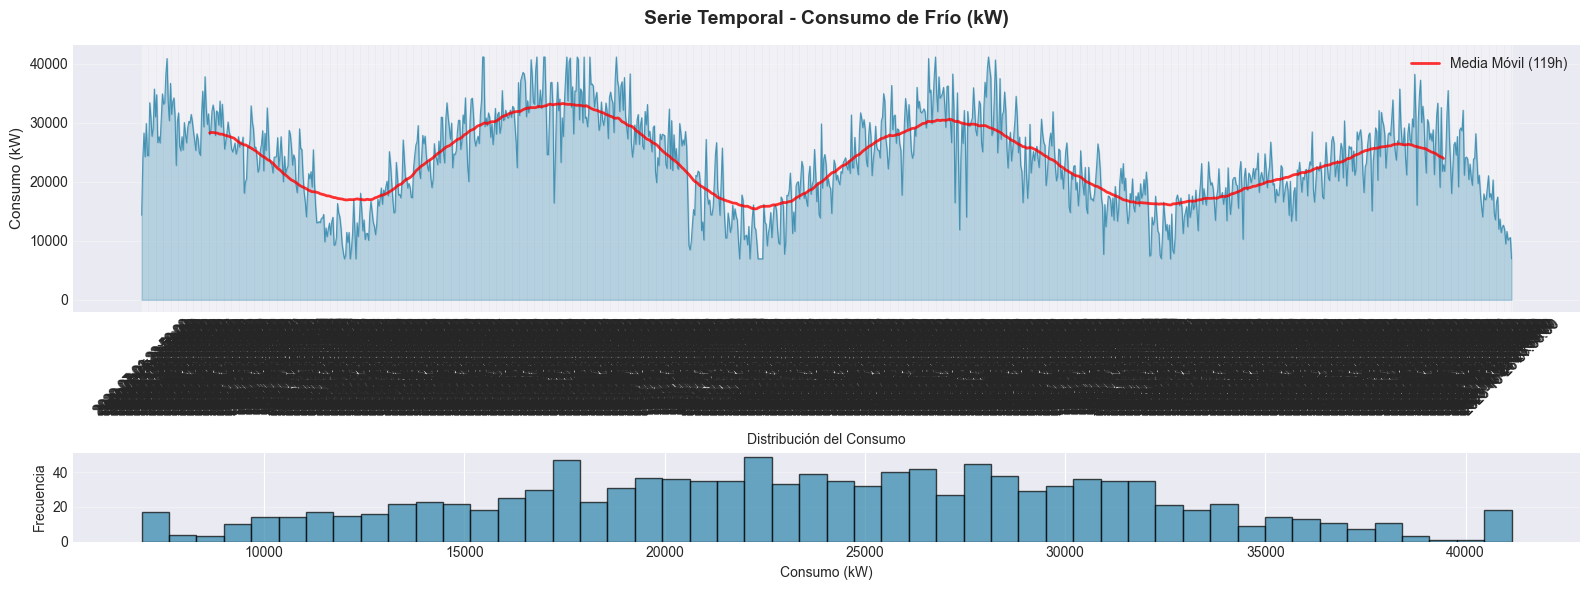


2️⃣  Boxplots Mensuales - Estacionalidad...


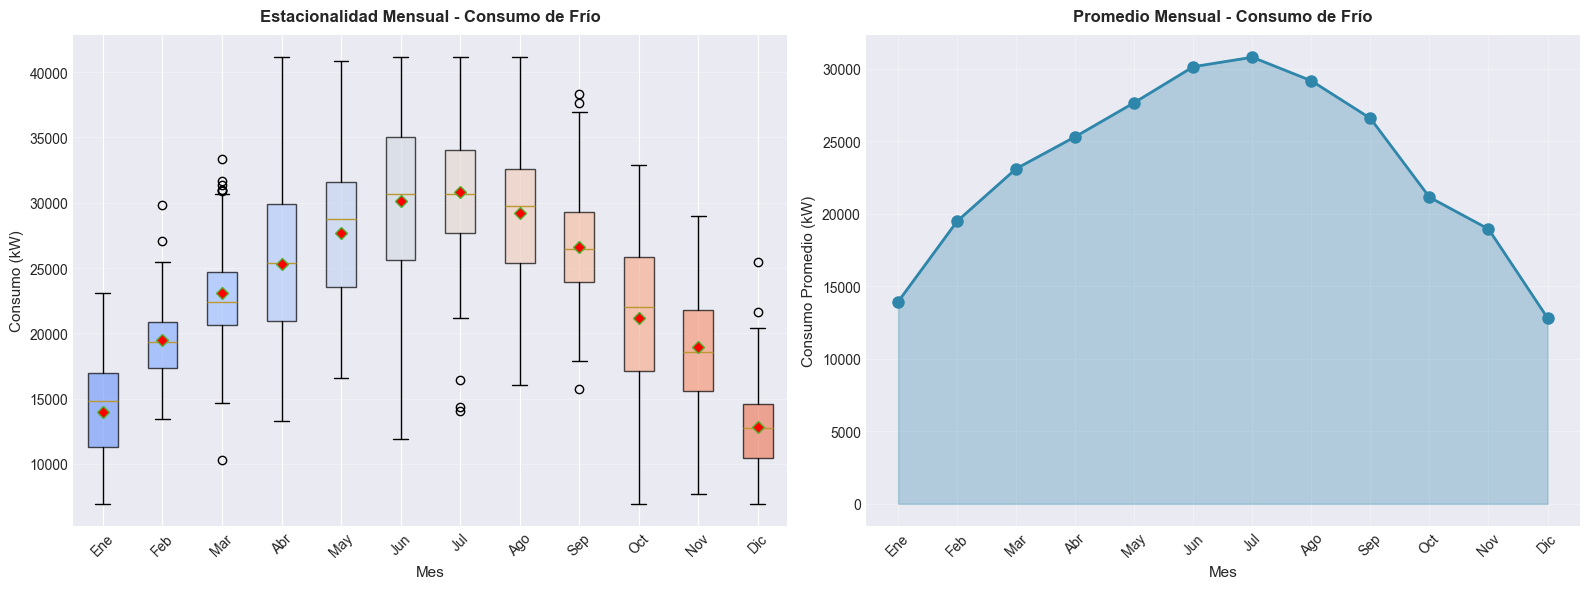


3️⃣  Distribución del Target...

📊 TEST DE NORMALIDAD (Shapiro-Wilk)
Estadístico: 0.9919
P-valor: 4.3070e-06
❌ Los datos NO siguen una distribución normal (p < 0.05)


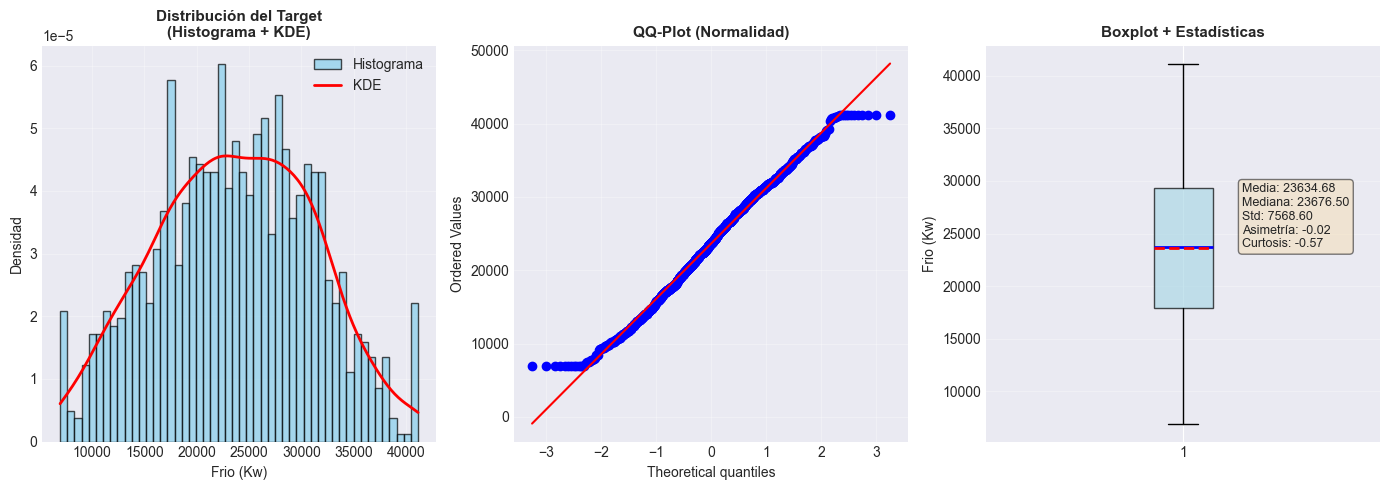


✅ VISUALIZACIONES COMPLETADAS


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# =============================================================================
# 1. SERIE TEMPORAL DEL CONSUMO DE FRÍO (kW)
# =============================================================================

def plot_serie_temporal_frio(df, target_col='Frio_kW', fecha_col='fecha', figsize=(16, 6)):
    """
    Visualiza la serie temporal del consumo de frío
    """
    fig, axes = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])
    
    # Serie temporal completa
    axes[0].plot(df[fecha_col], df[target_col], linewidth=0.8, alpha=0.8, color='#2E86AB')
    axes[0].fill_between(df[fecha_col], df[target_col], alpha=0.3, color='#2E86AB')
    axes[0].set_title('Serie Temporal - Consumo de Frío (kW)', 
                      fontsize=14, fontweight='bold', pad=15)
    axes[0].set_ylabel('Consumo (kW)', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Promedio móvil
    window = min(24*7, len(df)//10)  # Ventana de 1 semana o 10% de datos
    if window > 1:
        rolling_mean = df[target_col].rolling(window=window, center=True).mean()
        axes[0].plot(df[fecha_col], rolling_mean, 
                    color='red', linewidth=2, label=f'Media Móvil ({window}h)', alpha=0.8)
        axes[0].legend(loc='upper right')
    
    # Distribución (histograma pequeño)
    axes[1].hist(df[target_col], bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Consumo (kW)', fontsize=10)
    axes[1].set_ylabel('Frecuencia', fontsize=10)
    axes[1].set_title('Distribución del Consumo', fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig


# =============================================================================
# 2. BOXPLOTS MENSUALES - ESTACIONALIDAD
# =============================================================================

def plot_boxplots_mensuales(df, target_col='Frio_kW', fecha_col='fecha', figsize=(16, 6)):
    """
    Boxplots por mes para identificar estacionalidad
    """
    # Crear columna de mes si no existe
    df_temp = df.copy()
    if 'mes' not in df_temp.columns:
        df_temp['mes'] = pd.to_datetime(df_temp[fecha_col]).dt.month
    if 'año' not in df_temp.columns:
        df_temp['año'] = pd.to_datetime(df_temp[fecha_col]).dt.year
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Boxplot por mes
    meses_nombres = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    
    bp1 = axes[0].boxplot(
        [df_temp[df_temp['mes'] == m][target_col].dropna() for m in range(1, 13)],
        labels=meses_nombres,
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='red', markersize=6)
    )
    
    # Colorear boxplots
    colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, 12))
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[0].set_title('Estacionalidad Mensual - Consumo de Frío', 
                      fontsize=12, fontweight='bold', pad=10)
    axes[0].set_ylabel('Consumo (kW)', fontsize=11)
    axes[0].set_xlabel('Mes', fontsize=11)
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Promedio mensual con línea
    monthly_avg = df_temp.groupby('mes')[target_col].mean()
    axes[1].plot(range(1, 13), monthly_avg, marker='o', linewidth=2, 
                 markersize=8, color='#2E86AB')
    axes[1].fill_between(range(1, 13), monthly_avg, alpha=0.3, color='#2E86AB')
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(meses_nombres, rotation=45)
    axes[1].set_title('Promedio Mensual - Consumo de Frío', 
                      fontsize=12, fontweight='bold', pad=10)
    axes[1].set_ylabel('Consumo Promedio (kW)', fontsize=11)
    axes[1].set_xlabel('Mes', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# =============================================================================
# 3. DISTRIBUCIÓN DEL TARGET (HISTOGRAMA Y QQ-PLOT)
# =============================================================================

def plot_distribucion_target(df, target_col='Frio_kW', figsize=(14, 5)):
    """
    Análisis de distribución: histograma, KDE y QQ-plot
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    data = df[target_col].dropna()
    
    # 1. Histograma con KDE
    axes[0].hist(data, bins=50, density=True, alpha=0.7, 
                 color='skyblue', edgecolor='black', label='Histograma')
    
    # KDE
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 200)
    axes[0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    axes[0].set_title('Distribución del Target\n(Histograma + KDE)', 
                      fontsize=11, fontweight='bold')
    axes[0].set_xlabel(f'{target_col}', fontsize=10)
    axes[0].set_ylabel('Densidad', fontsize=10)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. QQ-Plot (normalidad)
    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].set_title('QQ-Plot (Normalidad)', fontsize=11, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Boxplot con estadísticas
    bp = axes[2].boxplot(data, vert=True, patch_artist=True, 
                          showmeans=True, meanline=True,
                          meanprops=dict(color='red', linewidth=2),
                          medianprops=dict(color='blue', linewidth=2))
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    
    # Agregar estadísticas
    stats_text = f'Media: {data.mean():.2f}\n'
    stats_text += f'Mediana: {data.median():.2f}\n'
    stats_text += f'Std: {data.std():.2f}\n'
    stats_text += f'Asimetría: {data.skew():.2f}\n'
    stats_text += f'Curtosis: {data.kurtosis():.2f}'
    
    axes[2].text(1.15, data.median(), stats_text, fontsize=9,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    axes[2].set_title('Boxplot + Estadísticas', fontsize=11, fontweight='bold')
    axes[2].set_ylabel(f'{target_col}', fontsize=10)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Test de normalidad
    shapiro_stat, shapiro_p = stats.shapiro(data.sample(min(5000, len(data))))
    print("\n" + "="*60)
    print("📊 TEST DE NORMALIDAD (Shapiro-Wilk)")
    print("="*60)
    print(f"Estadístico: {shapiro_stat:.4f}")
    print(f"P-valor: {shapiro_p:.4e}")
    if shapiro_p < 0.05:
        print("❌ Los datos NO siguen una distribución normal (p < 0.05)")
    else:
        print("✅ Los datos podrían seguir una distribución normal (p >= 0.05)")
    print("="*60)
    
    return fig


# =============================================================================
# 4. SCATTER PLOTS - TOP 5 VARIABLES MÁS CORRELACIONADAS
# =============================================================================

def plot_top_correlaciones(df, target_col='Frio_kW', top_vars=None, n_top=5, figsize=(16, 10)):
    """
    Scatter plots de las top N variables más correlacionadas con el target
    """
    # Si no se proporcionan las variables, calcularlas
    if top_vars is None:
        corr_with_target = df.corr()[target_col].abs().sort_values(ascending=False)
        top_vars = corr_with_target[1:n_top+1].index.tolist()  # Excluir el target mismo
    else:
        top_vars = top_vars[:n_top]
    
    n_vars = len(top_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_vars > 1 else [axes]
    
    for idx, var in enumerate(top_vars):
        ax = axes[idx]
        
        # Scatter plot
        ax.scatter(df[var], df[target_col], alpha=0.5, s=20, color='steelblue')
        
        # Línea de regresión
        z = np.polyfit(df[var].dropna(), df[target_col].loc[df[var].dropna().index], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df[var].min(), df[var].max(), 100)
        ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8)
        
        # Correlación
        corr = df[var].corr(df[target_col])
        
        ax.set_xlabel(var, fontsize=10)
        ax.set_ylabel(target_col, fontsize=10)
        ax.set_title(f'{var}\nCorr: {corr:.3f}', fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Ocultar ejes sobrantes
    for idx in range(n_vars, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'Top {n_vars} Variables Más Correlacionadas con {target_col}', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return fig


# =============================================================================
# 5. ANÁLISIS DE CONSUMO POR ÁREA DE LA PLANTA
# =============================================================================

def plot_consumo_por_area(df, target_col='Frio_kW', area_cols=None, figsize=(16, 10)):
    """
    Análisis de consumo por áreas de la planta (Elaboración, Envasado, etc.)
    
    Parameters:
    -----------
    df : DataFrame
    target_col : columna del target
    area_cols : lista de columnas que representan áreas (si es None, se detectan automáticamente)
    """
    
    # Detectar columnas de áreas automáticamente si no se proporcionan
    if area_cols is None:
        # Buscar columnas que contengan palabras clave de áreas
        keywords = ['elaboracion', 'envasado', 'camara', 'area', 'zona', 
                   'sector', 'linea', 'sala', 'deposito', 'almacen']
        area_cols = []
        for col in df.columns:
            if any(keyword in col.lower() for keyword in keywords):
                area_cols.append(col)
        
        if len(area_cols) == 0:
            print("⚠️  No se detectaron columnas de áreas automáticamente.")
            print("    Por favor, proporciona las columnas manualmente.")
            return None
    
    n_areas = len(area_cols)
    
    if n_areas == 0:
        print("⚠️  No hay áreas para analizar")
        return None
    
    # Crear figura con múltiples subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Boxplots comparativos
    ax1 = fig.add_subplot(gs[0, :])
    df_areas = df[area_cols].copy()
    bp = ax1.boxplot([df_areas[col].dropna() for col in area_cols],
                      labels=area_cols,
                      patch_artist=True,
                      showmeans=True)
    
    # Colorear
    colors = plt.cm.Set3(np.linspace(0, 1, n_areas))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_title('Comparación de Consumo por Área', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Consumo (kW)', fontsize=10)
    ax1.tick_params(axis='x', rotation=45, labelsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Contribución porcentual (pie chart)
    ax2 = fig.add_subplot(gs[1, 0])
    totales = df[area_cols].sum()
    ax2.pie(totales, labels=area_cols, autopct='%1.1f%%', startangle=90, colors=colors)
    ax2.set_title('Distribución Porcentual del Consumo', fontsize=11, fontweight='bold')
    
    # 3. Barras de consumo promedio
    ax3 = fig.add_subplot(gs[1, 1])
    promedios = df[area_cols].mean().sort_values(ascending=False)
    bars = ax3.barh(range(len(promedios)), promedios.values, color=colors)
    ax3.set_yticks(range(len(promedios)))
    ax3.set_yticklabels(promedios.index, fontsize=9)
    ax3.set_xlabel('Consumo Promedio (kW)', fontsize=10)
    ax3.set_title('Consumo Promedio por Área', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Agregar valores en las barras
    for i, (bar, val) in enumerate(zip(bars, promedios.values)):
        ax3.text(val, i, f' {val:.1f}', va='center', fontsize=8)
    
    # 4. Serie temporal de áreas principales (top 3)
    ax4 = fig.add_subplot(gs[2, :])
    top_3_areas = totales.nlargest(3).index
    
    for area in top_3_areas:
        if 'fecha' in df.columns:
            ax4.plot(df['fecha'], df[area], label=area, linewidth=1, alpha=0.7)
        else:
            ax4.plot(df.index, df[area], label=area, linewidth=1, alpha=0.7)
    
    ax4.set_title('Evolución Temporal - Top 3 Áreas', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Consumo (kW)', fontsize=10)
    ax4.set_xlabel('Tiempo', fontsize=10)
    ax4.legend(loc='upper right', fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    fig.suptitle('Análisis de Consumo por Área de la Planta', 
                 fontsize=14, fontweight='bold', y=0.995)
    
    # Imprimir estadísticas
    print("\n" + "="*80)
    print("📊 ESTADÍSTICAS POR ÁREA")
    print("="*80)
    stats_df = pd.DataFrame({
        'Media': df[area_cols].mean(),
        'Mediana': df[area_cols].median(),
        'Std': df[area_cols].std(),
        'Total': df[area_cols].sum(),
        '% Total': (df[area_cols].sum() / df[area_cols].sum().sum() * 100)
    }).sort_values('Total', ascending=False)
    
    print(stats_df.to_string())
    print("="*80)
    
    return fig


# =============================================================================
# 6. FUNCIÓN PRINCIPAL - EJECUTAR TODAS LAS VISUALIZACIONES
# =============================================================================

def generar_visualizaciones_completas(df, target_col='Frio_kW', fecha_col='fecha',
                                     top_vars=None, area_cols=None):
    """
    Genera todas las visualizaciones requeridas
    
    Parameters:
    -----------
    df : DataFrame con los datos
    target_col : nombre de la columna target
    fecha_col : nombre de la columna de fecha
    top_vars : lista de top variables correlacionadas (opcional)
    area_cols : lista de columnas de áreas (opcional)
    """
    
    print("\n" + "="*80)
    print("📊 GENERANDO VISUALIZACIONES COMPLETAS")
    print("="*80)
    
    # 1. Serie temporal
    print("\n1️⃣  Serie Temporal del Consumo de Frío...")
    fig1 = plot_serie_temporal_frio(df, target_col, fecha_col)
    plt.show()
    
    # 2. Boxplots mensuales
    print("\n2️⃣  Boxplots Mensuales - Estacionalidad...")
    fig2 = plot_boxplots_mensuales(df, target_col, fecha_col)
    plt.show()
    
    # 3. Distribución del target
    print("\n3️⃣  Distribución del Target...")
    fig3 = plot_distribucion_target(df, target_col)
    plt.show()
    

    

    
    print("\n" + "="*80)
    print("✅ VISUALIZACIONES COMPLETADAS")
    print("="*80)
    
    return {
        'serie_temporal': fig1,
        'boxplots_mensuales': fig2,
        'distribucion_target': fig3,

    }


# =============================================================================
# EJEMPLO DE USO
# =============================================================================
df = pd.read_csv("../data\processed/foundational_dataset.csv")
#hago winsorización solo para el Frio (Kw)
from scipy.stats.mstats import winsorize

# Winsorizar al 1% y 99% (elimina extremos más severos)
df["Frio (Kw)"] = winsorize(df["Frio (Kw)"], limits=[0.01, 0.01])# # Caso 1: Ejecución completa automática
figuras = generar_visualizaciones_completas(
     df=df,  # Tu DataFrame
     target_col='Frio (Kw)',
     fecha_col="FECHA_HORA"
)
#
# # Caso 2: Con variables específicas
# top_vars = preview.head(5).index.tolist()  # Del análisis de correlación
# area_cols = ['elaboracion_kW', 'envasado_kW', 'camara_frio_kW']
#
# figuras = generar_visualizaciones_completas(
#     df=df_completo,
#     target_col='Frio_kW',
#     fecha_col='fecha',
#     top_vars=top_vars,
#     area_cols=area_cols
# )
#
# # Caso 3: Visualizaciones individuales
# plot_serie_temporal_frio(df_completo, 'Frio_kW', 'fecha')
# plt.show()
#
# plot_boxplots_mensuales(df_completo, 'Frio_kW', 'fecha')
# plt.show()

In [ ]:
#Finalmente, vamos a guardar los resultados del analisis exploratorio
#nuestros conjuntos x_train, y_train, x_test, y_test

def descargar_dataframe_como_csv(df, nombre_archivo="datos_descargados.csv"):
    """
    Guarda un DataFrame de Pandas como un archivo CSV y 
    fuerza la descarga en el navegador si se ejecuta en Colab o Jupyter.
    """
    try:
        # 1. Guardar el archivo en el disco local del entorno
        df.to_csv(nombre_archivo, index=False, encoding='utf-8')
        print(f"✅ DataFrame guardado exitosamente como '{nombre_archivo}' en el entorno local.")

        # 2. Lógica para forzar la descarga al ordenador del usuario
        # ---
        


    except Exception as e:
        print(f"❌ Ocurrió un error al guardar o descargar el archivo: {e}")

descargar_dataframe_como_csv(x_train, "../data\processed\splits\x_train.csv")
descargar_dataframe_como_csv(x_test, "../data\processed\splits\x_test.csv")
descargar_dataframe_como_csv(y_train, "../data\processed\splits\y_train.csv")
descargar_dataframe_como_csv(y_test, "../data\processed\splits\y_test.csv")


✅ DataFrame guardado exitosamente como 'x_train.csv' en el entorno local.
✅ DataFrame guardado exitosamente como 'x_test.csv' en el entorno local.
✅ DataFrame guardado exitosamente como 'y_train.csv' en el entorno local.
✅ DataFrame guardado exitosamente como 'y_test.csv' en el entorno local.
